In [1]:
%pylab inline
#from ipywidgets import *
from IPython.html.widgets import *

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
s0=matrix([[1,0],[0,1]])
s1=matrix([[0,1],[1,0]])
s2=matrix([[0,-1j],[1j,0]])
s3=matrix([[1,0],[0,-1]])
z2=zeros_like(s0);

In [3]:
def h(kx,ky,mz,mm,phi):
    a1=array([0.5,sqrt(3)/2])
    a2=array([-0.5,sqrt(3)/2])
    k=array([kx,ky])
    w1=exp(1j*dot(a1,k))
    w2=exp(1j*dot(a2,k))
    U=kron((s1+1j*s2)/2,s0+1.j*(mz*s3+mm*cos(phi)*s1+mm*sin(phi)*s2))
    U=U+U.H
    T1=kron((s1+1j*s2)/2,s0+1.j*(mz*s3+mm*cos(phi+2/3*pi)*s1+mm*sin(phi+2/3*pi)*s2))
    T2=kron((s1+1j*s2)/2,s0+1.j*(mz*s3+mm*cos(phi-2/3*pi)*s1+mm*sin(phi-2/3*pi)*s2))
    
    return U+w1*T1+w2*T2+(w1*T1+w2*T2).H

In [4]:
yrange=linspace(-2.1*sqrt(3),0,90)
xrange=linspace(0,2*pi,180)
krange=array([append(0*yrange,xrange),append(yrange,0*xrange)]).T
kspace=linspace(0,len(xrange)+len(yrange),len(xrange)+len(yrange));
dk=.8
kX,kY=meshgrid(linspace(4*pi/3-dk,4*pi/3+dk,50),linspace(-dk,dk,50))
SX=kron(s0,s1)
SY=kron(s0,s2)
SZ=kron(s0,s3)

In [5]:
def play(mz=0,mm=0,phi=0,en=0.3):
    dat=[]
    for x,y in krange:
        dat.append(eigvalsh(h(x,y,mz,mm,phi)))        
    plot(kspace,dat,'k-',lw=3);
    plot(kspace,en*kspace**0,'k--',lw=3);
    ylim(-3.5,3.5)
    ylabel(r'$E/\gamma_0$',fontsize=20)
    xlim(0,len(xrange)+len(yrange))
    xticks([0,len(yrange),2/3*len(xrange)+len(yrange),len(xrange)+len(yrange)],
           [r'$M$',r'$\Gamma$',r'$K$',r'$M$'],fontsize=20)
    grid()

def playcont(mz=0,mm=0,phi=0,en=0.3):
    dat2d=[]
    for x,y in array([kX.flatten(),kY.flatten()]).T :
        dat2d.append(eigvalsh(h(x,y,mz,mm,phi)))
    c=[contour(kX,kY,reshape(array(dat2d)[:,2],kX.shape),[en],linewidths=[3],colors='k'),
       contour(kX,kY,reshape(array(dat2d)[:,3],kX.shape),[en],linewidths=[3],colors='k')]
    for i in range(len(c)):
        for kx,ky in c[i].allsegs[0][0][::5]:
            w,v=eigh(h(kx,ky,mz,mm,phi))
            vecx=real((v[:,2].H*SX*v[:,2])[0,0])/3
            vecy=real((v[:,2].H*SY*v[:,2])[0,0])/3  
            arrow(kx,ky,vecx,vecy,color='blue')
    plot(4*pi/3,0,'ko',ms=15)
    text(4*pi/3+0.1,0,r'$K$',fontsize=20)
    xticks([])
    yticks([])
    ylabel(r'$k_y$',fontsize=20)
    xlabel(r'$k_x$',fontsize=20);


/usr/local/lib/python3.4/dist-packages/matplotlib/patches.py:1147: RuntimeWarning: invalid value encountered in double_scalars
  cx = float(dx) / distance
/usr/local/lib/python3.4/dist-packages/matplotlib/patches.py:1148: RuntimeWarning: invalid value encountered in double_scalars
  sx = float(dy) / distance


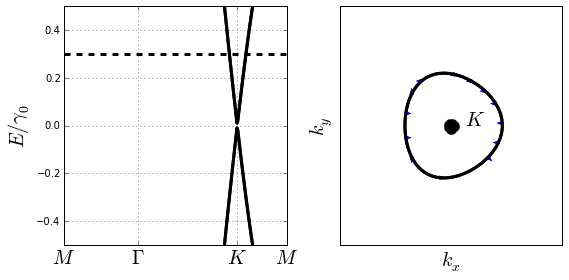

In [6]:
figsize(8,4)
@interact(mz=(0,.14,0.01),mm=(0,.14,0.01),phi=(0,2*pi,0.01*pi),en=(0,3,0.1))
def abragyar(mz=0,mm=0,phi=0,en=0.3):
    subplot(1,2,1)
    play(mz,mm,phi,en)
    ylim(-0.5,0.5)
    subplot(1,2,2)
    playcont(mz,mm,phi,en)
    tight_layout()

In [7]:
def wilson_loop(hamfun,*hamargs,
                b1=array([2*pi,0]),
                b2=array([0,2*pi]),
                p1ran=linspace(0,0.5,100),
                p2ran=linspace(0,1,7,endpoint=False),
                **kwargs):
    '''
    Calculating Z2 invariant via Wilson loops of slices 
    of the occupied bands in k-space,
    given a function hamfun(kx,ky,*hamargs)
    and k space reciprocal lattice vectors b1,b2.
    '''
    dim=len(hamfun(0,0,*hamargs))
    dat=[]
    for p1 in p1ran:
        WL=eye(dim)
        for p2 in p2ran:
            kx=(p1*b1+p2*b2)[0]
            ky=(p1*b1+p2*b2)[1]
            H=hamfun(kx,ky,*hamargs)
            eigdat=eigh(H);
            P=eigdat[1][:,eigdat[0]<0]*eigdat[1][:,eigdat[0]<0].H
            WL=P*WL
        weig=eig(WL);
        indx=where(abs(weig[0])>10**-10)[0]
        dat.append(sort(angle(weig[0][indx])))       
        
    return  (p1ran,dat)

In [8]:
def matafn(h):
    'Array flatten a matrix list of appropriate dimensions'
    H=hstack(h[0])
    for sor in range(1,len(h)):
        H=vstack([H,hstack(h[sor])])
    return H


In [9]:
def h_KM(kx,ky,mz):
    a1=array([0.5,sqrt(3)/2])
    a2=array([-0.5,sqrt(3)/2])
    k=array([kx,ky])
    w1=exp(1j*dot(a1,k))
    w2=exp(1j*dot(a2,k))
    w3=exp(1j*dot(a1+a2,k))
    U=matafn([[0*s0,s0],
              [s0,0*s0]]) 
    T1=matafn([[-1j*mz*s3,s0],
               [0*s0,1j*mz*s3]])
    T2=matafn([[-1j*mz*s3,0*s0],
               [s0,1j*mz*s3]])

    T3=matafn([[1j*mz*s3,0*s0],
               [0*s0,-1j*mz*s3]])
    return U+w1*T1+w2*T2+w3*T3+(w1*T1+w2*T2+w3*T3).H

In [10]:
eigvalsh(h_KM(0,0,0))

array([-3., -3.,  3.,  3.])

In [11]:
def play_KM(mz=0):
    dat=[]
    for x,y in krange:
        dat.append(eigvalsh(h_KM(y,x,mz)))        
    plot(kspace,dat,'k-',lw=3);
    ylim(-3.5,3.5)
    ylabel(r'$E/\gamma_0$',fontsize=20)
    xlim(0,len(xrange)+len(yrange))
    xticks([0,len(yrange),2/3*len(xrange)+len(yrange),len(xrange)+len(yrange)],
           [r'$M$',r'$\Gamma$',r'$K$',r'$M$'],fontsize=20)
    grid()

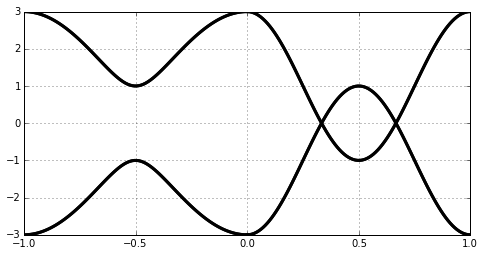

In [12]:
dat=[]
for k in linspace(-4*pi,0,100):
    dat.append(eigvalsh(h_KM(k,0,0)))
plot(linspace(-1,0,100),dat,'k-',lw=3);
dat=[]
for k in linspace(0,4*pi/sqrt(3),100):
    dat.append(eigvalsh(h_KM(0,k,0)))
plot(linspace(0,1,100),dat,'k-',lw=3);
grid()

In [30]:
ran,dat=wilson_loop(h_KM,*[0.3],b1=2*pi*array([1,1/sqrt(3)]),b2=2*pi*array([1,-1/sqrt(3)]),p1ran=linspace(0,0.5,1000))

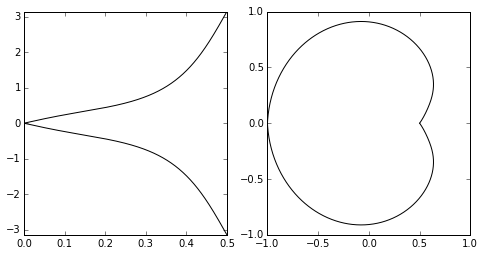

In [31]:
figsize(8,4)
subplot(121)
plot(ran,dat,'k-');
ylim(-pi,pi);
subplot(122)
for i in range(len(dat[0])):
    plot((ran+0.5)*cos(array(dat)[:,i]),
         (ran+0.5)*sin(array(dat)[:,i]),'k-')
xlim(-1,1)
ylim(-1,1);